In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Data Augmentation

Inicialmente

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


montando os arquivos csv

In [ ]:
# import csv
# import re

FOLDER_PATH = '/content/drive/MyDrive/Datasets/redes_automotivas'

file_names = ['NORMAL_SAMPLES.txt', 'FALSIFYING_ATCK.txt', 'FUZZING_ATCK.txt', 'IMPERSONATION_ATCK.txt', 'DOS_ATCK.txt']

# txt_files_content = []

column_titles = ["timestamp", "net", "data", "label"]

# for file_name in file_names:
#   txt_file_path = FOLDER_PATH + '/' + file_name
#   # Read the content of the TXT file
#   with open(txt_file_path, 'r') as file:
#       txt_files_content.append(file.readlines())

# for count, txt_file_content in enumerate(txt_files_content):
#   csv_file_path = FOLDER_PATH + '/CSV/' + file_names[count].split('.')[0] + '.csv'
#   with open(csv_file_path, 'w', newline='') as csvfile:
#       csvwriter = csv.writer(csvfile)
#       csvwriter.writerow(column_titles)
#       for line in txt_file_content:
#           row = re.split(r'\s+', line.strip())  # Split by one or more whitespace characters
#           csvwriter.writerow(row)





Montando os datasets

In [ ]:
import pandas as pd

classes = {
  'normal': 0,
  'DOS': 1,
  'FUZZ': 2,
  'IMPERSONATION': 3,
  'FALSIFYING': 4
}

def create_matrices_and_labels(df, class_t, num_rows=28, overlap=14):
    matrices = []
    labels = []
    step_size = num_rows - overlap  # Tamanho do passo para a sobreposição

    num_matrices = (len(df) - overlap) // step_size
    print('num_matrices:', num_matrices)

    for i in range(num_matrices):
        start_idx = i * step_size
        block = df.iloc[start_idx:start_idx + num_rows]
        if block.empty or len(block) < num_rows:
            continue

        binary_matrix = []
        for hex_value in block['data']:
            hex_value = hex_value.split('#')[0]
            binary_string = bin(int(hex_value, 16))[2:].zfill(16)
            binary_list = [int(bit) for bit in binary_string]
            binary_matrix.append(binary_list)

        if len(binary_matrix) == num_rows and all(len(row) == 16 for row in binary_matrix):
            matrix = torch.tensor(binary_matrix, dtype=torch.float32)
            label = classes[class_t] if 'T' in block['label'].values else 0
            matrices.append(matrix)
            labels.append(label)

    return matrices, labels

In [ ]:
normal_df = pd.read_csv(FOLDER_PATH + '/CSV/' + 'NORMAL_SAMPLES.csv')

normalized_df, labels = create_matrices_and_labels(normal_df, 'normal')

len(normalized_df), len(labels)
# normal_df.head()

num_matrices: 17856


(17856, 17856)

In [ ]:
dos_df = pd.read_csv(FOLDER_PATH + '/CSV/' + 'DOS_ATCK.csv')
normalized_df_dos, labels_dos = create_matrices_and_labels(dos_df, 'DOS')

fuzz_df = pd.read_csv(FOLDER_PATH + '/CSV/' + 'FUZZING_ATCK.csv')
normalized_df_fuzz, labels_fuzz = create_matrices_and_labels(fuzz_df, 'FUZZ')

impersonation_df = pd.read_csv(FOLDER_PATH + '/CSV/' + 'IMPERSONATION_ATCK.csv')
normalized_df_impersonation, labels_impersonation = create_matrices_and_labels(impersonation_df, 'IMPERSONATION')

false_df = pd.read_csv(FOLDER_PATH + '/CSV/' + 'FALSIFYING_ATCK.csv')
normalized_df_false, labels_false = create_matrices_and_labels(false_df, 'FALSIFYING')

num_matrices: 49999
num_matrices: 49999
num_matrices: 49999
num_matrices: 49999


In [ ]:
len(normalized_df_dos), len(normalized_df_fuzz), len(normalized_df_impersonation), len(normalized_df_false)

(49999, 49999, 49999, 49999)

In [ ]:
from sklearn.model_selection import train_test_split

normal_df_train, normal_df_val, labels_train, labels_val = train_test_split(normalized_df, labels, test_size=0.25, random_state=42)
dos_df_train, dos_df_val, labels_train_dos, labels_val_dos = train_test_split(normalized_df_dos, labels_dos, test_size=0.25, random_state=42)
fuzz_df_train, fuzz_df_val, labels_train_fuzz, labels_val_fuzz = train_test_split(normalized_df_fuzz, labels_fuzz, test_size=0.25, random_state=42)
impersonation_df_train, impersonation_df_val, labels_train_impersonation, labels_val_impersonation = train_test_split(normalized_df_impersonation, labels_impersonation, test_size=0.25, random_state=42)
false_df_train, false_df_val, labels_train_false, labels_val_false = train_test_split(normalized_df_false, labels_false, test_size=0.25, random_state=42)




In [ ]:
#train
all_matrices_train = normal_df_train + dos_df_train + fuzz_df_train + impersonation_df_train + false_df_train
all_labels_train = labels_train + labels_train_dos + labels_train_fuzz + labels_train_impersonation + labels_train_false

#validation
all_matrices_validation = normal_df_val + dos_df_val + fuzz_df_val + impersonation_df_val + false_df_val
all_labels_validation = labels_val + labels_val_dos + labels_val_fuzz + labels_val_impersonation + labels_val_false

In [ ]:
types_set = set()

for x in all_labels_train:
  types_set.add(type(x))

types_set

{int}

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, matrices, labels):
        self.matrices = matrices
        self.labels = labels

    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        matrix = self.matrices[idx]
        label = self.labels[idx]
        return matrix, label

In [ ]:
from torch.utils.data import DataLoader

# Criar uma instância do dataset de treino
train_dataset = CustomDataset(all_matrices_train, all_labels_train)

# Criar o DataLoader
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Criar uma instância do dataset de validação
validation_dataset = CustomDataset(all_matrices_validation, all_labels_validation)

# Criar o DataLoader
dataloader_validation = DataLoader(validation_dataset, batch_size=32, shuffle=True)

In [ ]:
for i, (batch_matrices, batch_labels) in enumerate(dataloader_train):
    print(f"Batch {i+1}:")
    print(f"Batch matrices shape: {batch_matrices.shape}")
    print(f"Batch labels: {batch_labels}")

    # Mostrar os primeiros 5 exemplos do batch
    # for j in range(min(5, len(batch_matrices))):
    #     print(f"Example {j+1}:")
    #     print(f"Matrix:\n{batch_matrices[j]}")
    #     print(f"Label: {batch_labels[j]}")

    # Apenas para demonstração, pare após o primeiro batch
    if i == 5:
        break

Batch 1:
Batch matrices shape: torch.Size([32, 28, 16])
Batch labels: tensor([4, 3, 2, 4, 3, 3, 2, 1, 4, 1, 0, 3, 3, 3, 2, 1, 4, 1, 0, 4, 2, 1, 4, 3,
        4, 2, 4, 2, 1, 3, 4, 1])
Batch 2:
Batch matrices shape: torch.Size([32, 28, 16])
Batch labels: tensor([1, 1, 3, 3, 3, 4, 4, 2, 4, 3, 2, 3, 3, 3, 1, 2, 4, 3, 0, 1, 2, 2, 4, 4,
        3, 2, 2, 1, 4, 3, 4, 2])
Batch 3:
Batch matrices shape: torch.Size([32, 28, 16])
Batch labels: tensor([4, 3, 4, 0, 3, 4, 3, 3, 2, 3, 2, 4, 3, 2, 1, 3, 4, 3, 4, 4, 2, 2, 4, 3,
        3, 3, 1, 3, 2, 1, 4, 0])
Batch 4:
Batch matrices shape: torch.Size([32, 28, 16])
Batch labels: tensor([4, 1, 3, 4, 1, 1, 2, 4, 1, 1, 2, 1, 4, 2, 1, 0, 4, 2, 3, 4, 0, 1, 1, 0,
        4, 3, 1, 3, 0, 3, 4, 1])
Batch 5:
Batch matrices shape: torch.Size([32, 28, 16])
Batch labels: tensor([0, 2, 2, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 2, 1, 3, 2, 0, 0, 1, 4, 0, 4,
        4, 1, 3, 0, 4, 2, 1, 3])
Batch 6:
Batch matrices shape: torch.Size([32, 28, 16])
Batch labels: tensor([2, 3, 1

# Model

A ideia aqui é utilizarmos a efficient net B0, já que se mostrou muito eficiente com um número muito pequeno de parametros. Caso não seja suficientemente bom, podemos migrar até a efficientnet B2, já que possui menos parametros que a inception resnet, o que é o modelo utilizado no artigo.

## Treinando o modelo

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

eff_b0_imgnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# eff_b0_imgnet

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
for param in eff_b0_imgnet.parameters():
    param.requires_grad = False

def set_random_seed(SEED):
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)

set_random_seed(42)

out_ftrs = 5

eff_b0_imgnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_ftrs = eff_b0_imgnet.classifier[1].in_features
eff_b0_imgnet.classifier[1] = nn.Linear(num_ftrs, out_ftrs)


summary(eff_b0_imgnet, input_size=(32, 1, 28, 16))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 5]                   --
├─Sequential: 1-1                                       [32, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 14, 8]           --
│    │    └─Conv2d: 3-1                                 [32, 32, 14, 8]           288
│    │    └─BatchNorm2d: 3-2                            [32, 32, 14, 8]           (64)
│    │    └─SiLU: 3-3                                   [32, 32, 14, 8]           --
│    └─Sequential: 2-2                                  [32, 16, 14, 8]           --
│    │    └─MBConv: 3-4                                 [32, 16, 14, 8]           (1,448)
│    └─Sequential: 2-3                                  [32, 24, 7, 4]            --
│    │    └─MBConv: 3-5                                 [32, 24, 7, 4]            (6,004)
│    │    └─MBConv: 3-6                        

In [ ]:
print(eff_b0_imgnet)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
from IPython.display import clear_output
import copy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def print_loss(train_loss, test_loss, train_acc, test_acc):
    clear_output(wait=True)
    x_values1, y_values1 = zip(*train_loss)
    x_values2, y_values2 = zip(*test_loss)
    x_values3, y_values3 = zip(*train_acc)
    x_values4, y_values4 = zip(*test_acc)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))


    axs[0].plot(x_values1, y_values1, linestyle='-', label='train loss')
    axs[0].plot(x_values2, y_values2, linestyle='--', label='test loss')

    axs[0].set_xlabel('Épocas')
    axs[0].set_ylabel('Valor da loss')
    axs[0].set_title('Variação da loss de treino e teste')
    axs[0].legend()

    axs[1].plot(x_values3, y_values3, linestyle='-', label='train accuracy')
    axs[1].plot(x_values4, y_values4, linestyle='--', label='test accuracy')

    axs[1].set_xlabel('Épocas')
    axs[1].set_ylabel('Valor da Precisão')
    axs[1].set_title('Variação da precisão de treino e teste')
    axs[1].legend()

    plt.show()

def train_model(model, train_dataloader, validation_dataloader, loss_fn, optimizer, device='cpu', epochs=10, scheduler=None, unfreeze_step = None):
  model = model.to(device)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  train_loss_list = []
  test_loss_list = []
  train_acc_list = []
  test_acc_list = []

  for epoch in range(epochs):

    print(f'Starting train for epoch {epoch + 1}')

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

      # print(f'Starting training batch: {batch + 1}')
      model.train()

      X, y = X.to(device), y.to(device)

      X = X.unsqueeze(1)

      y_logits = model(X)

      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

      train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

      loss = loss_fn(y_logits, y)

      train_loss += loss.item()

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model.eval()

    print(f'Starting validation for epoch {epoch + 1}')

    with torch.inference_mode():
      for batch, (X, y) in enumerate(validation_dataloader):
        # print(f'Starting validation batch: {batch + 1}')
        X, y = X.to(device), y.to(device)
        X = X.unsqueeze(1)

        test_logits = model(X)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss += loss_fn(test_logits, y)
        test_acc += accuracy_fn(y_true=y,
                                y_pred=test_pred)
      test_loss /= len(validation_dataloader)
      test_acc /= len(validation_dataloader)
      if scheduler != None:
        scheduler.step()

    if test_acc > best_acc:
      best_acc = test_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Ending epoch ${epoch + 1}')
    train_loss_list.append((epoch, train_loss))
    test_loss_list.append((epoch, test_loss.item()))
    train_acc_list.append((epoch, train_acc))
    test_acc_list.append((epoch, test_acc))
    print(type(train_loss), type(test_loss), type(train_acc), type(test_acc))
    print_loss(train_loss_list, test_loss_list, train_acc_list, test_acc_list)
    print(f"Loss: {loss:.5f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=eff_b0_imgnet.parameters(), lr=0.01)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=14, gamma=0.1)

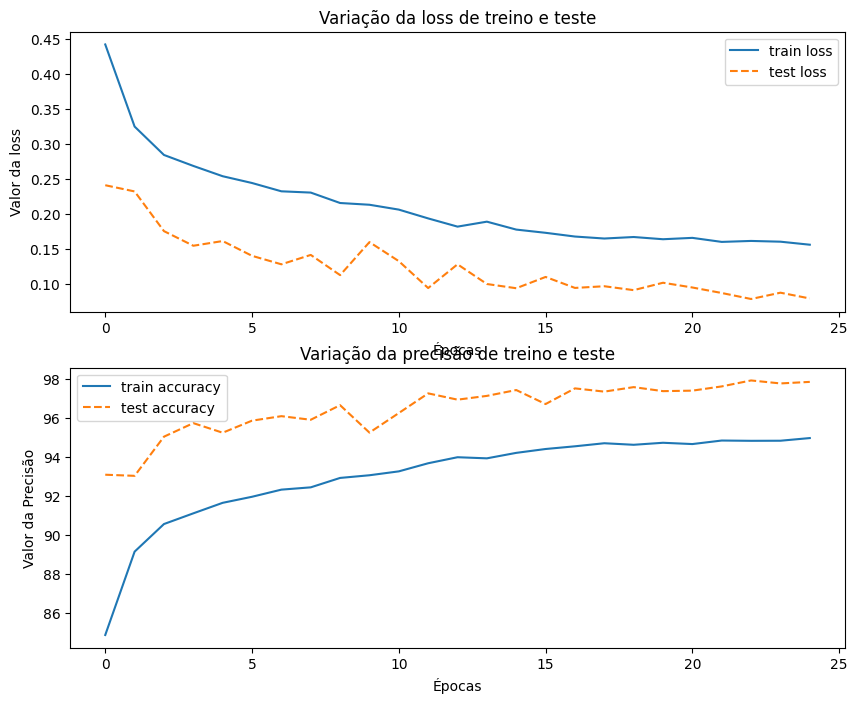

Loss: 0.03539 | Test Loss: 0.07944, Test Acc: 97.83%


In [ ]:
model = train_model(
    eff_b0_imgnet,
    dataloader_train,
    dataloader_validation,
    loss_fn,
    optimizer,
    'cuda',
    25,
    scheduler
)

In [ ]:
# torch.save(model.state_dict(), f'{FOLDER_PATH}/model')

## Validando o modelo

In [ ]:
from torchvision.models import efficientnet_b0
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

model = efficientnet_b0()
out_ftrs = 5

model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, out_ftrs)

model.load_state_dict(torch.load(f'{FOLDER_PATH}/model', map_location=torch.device('cpu')))

summary(model, input_size=(32, 1, 28, 16))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 5]                   --
├─Sequential: 1-1                                       [32, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 14, 8]           --
│    │    └─Conv2d: 3-1                                 [32, 32, 14, 8]           288
│    │    └─BatchNorm2d: 3-2                            [32, 32, 14, 8]           64
│    │    └─SiLU: 3-3                                   [32, 32, 14, 8]           --
│    └─Sequential: 2-2                                  [32, 16, 14, 8]           --
│    │    └─MBConv: 3-4                                 [32, 16, 14, 8]           1,448
│    └─Sequential: 2-3                                  [32, 24, 7, 4]            --
│    │    └─MBConv: 3-5                                 [32, 24, 7, 4]            6,004
│    │    └─MBConv: 3-6                              

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def get_model_accuracy(model, test_dl, device='cpu'):
  acc = 0

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in test_dl:
      X, y = X.to(device), y.to(device)
      X = X.unsqueeze(1)
      logits = model(X)
      pred = torch.softmax(logits, dim=1).argmax(dim=1)
      acc += accuracy_fn(y_true=y,
                              y_pred=pred)

  return acc/len(test_dl)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_pred_and_true_labels(model, dataloader, device='cpu'):
  preds = []
  true = []

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      X = X.unsqueeze(1)

      logits = model(X)
      pred = torch.softmax(logits, dim=1).argmax(dim=1)

      preds.extend(pred.tolist())
      true.extend(y.tolist())


  return preds, true


def print_confussion_matrix(model, dataloader):
  preds, true = get_pred_and_true_labels(model, dataloader)

  matriz_de_confusao = confusion_matrix(true, preds)

  sns.heatmap(matriz_de_confusao, annot=True, fmt="d")
  plt.show()

In [ ]:
model_acc = {
  'validation': get_model_accuracy(model, dataloader_validation),
  'train': get_model_accuracy(model, dataloader_train)
}

model_acc

{'validation': 97.90503819036428, 'train': 98.00899501986459}

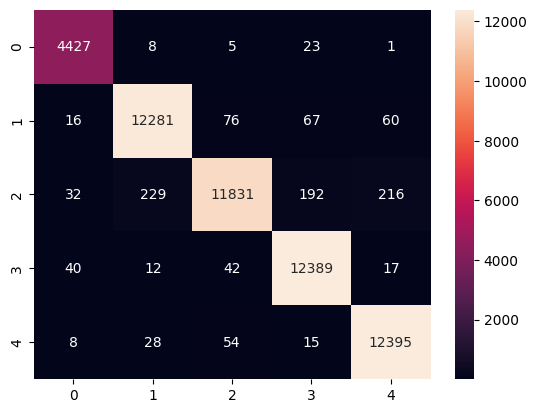

In [ ]:
print_confussion_matrix(model, dataloader_validation)

## Testando o modelo

### Com ataques DoS

In [ ]:
dos_dataset, dos_labels = create_matrices_and_labels(dos_df, 'DOS')
dos_dataset = CustomDataset(dos_dataset, dos_labels)

# Criar o DataLoader
dos_dataloader = DataLoader(dos_dataset, batch_size=1, shuffle=True)

num_matrices: 49999


In [ ]:
get_model_accuracy(model, dos_dataloader)

98.14796295925919

In [ ]:
fuzz_dataset, fuzz_labels = create_matrices_and_labels(fuzz_df, 'FUZZ')
fuzz_dataset = CustomDataset(fuzz_dataset, fuzz_labels)

# Criar o DataLoader
fuzz_dataloader = DataLoader(fuzz_dataset, batch_size=1, shuffle=True)
get_model_accuracy(model, fuzz_dataloader)

num_matrices: 49999


94.98789975799517

In [ ]:
impersonation_dataset, impersonation_labels = create_matrices_and_labels(impersonation_df, 'IMPERSONATION')
impersonation_dataset = CustomDataset(impersonation_dataset, impersonation_labels)

# Criar o DataLoader
impersonation_dataloader = DataLoader(impersonation_dataset, batch_size=1, shuffle=True)
get_model_accuracy(model, impersonation_dataloader)

num_matrices: 49999


99.1439828796576

In [ ]:
false_dataset, false_labels = create_matrices_and_labels(false_df, 'FALSIFYING')
false_dataset = CustomDataset(false_dataset, false_labels)

# Criar o DataLoader
false_dataloader = DataLoader(false_dataset, batch_size=1, shuffle=True)
get_model_accuracy(model, false_dataloader)

num_matrices: 49999


99.1819836396728

In [ ]:
default_df, default_labels = create_matrices_and_labels(normal_df, 'normal')
default_dataset = CustomDataset(default_df, default_labels)

# Criar o DataLoader
default_dataloader = DataLoader(default_dataset, batch_size=1, shuffle=True)
get_model_accuracy(model, default_dataloader)

num_matrices: 17856


99.29995519713262

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Supondo que você tem um DataLoader para seu conjunto de teste
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

new_dataloader_validation = DataLoader(validation_dataset, batch_size=32, shuffle=True)

# E um modelo CNN já treinado
# model = YourCNNModel()
# model.load_state_dict(torch.load('path_to_trained_model.pth'))
# model.eval()

# Para armazenar os labels verdadeiros e predições
y_true = []
y_pred = []

device = 'cpu'

# Desabilitar o cálculo de gradiente para economizar memória e acelerar a inferência
model.eval()
with torch.inference_mode():
    for inputs, labels in new_dataloader_validation:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        # Obter as predições (classe com maior pontuação)
        _, preds = torch.max(outputs, 1)

        # Acumular os resultados
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Contar os valores originais de cada classe no dataset
unique, counts = np.unique(y_true, return_counts=True)
original_counts = dict(zip(unique, counts))

# Inicializar DataFrame para armazenar os resultados
results = pd.DataFrame(index=['Normal', 'DOS', 'FUZZ', 'FALSIFIYNG', 'IMPERSONATION'],
                       columns=['Contagem original', 'TP', 'FP', 'FN'])

# Preencher DataFrame com Original Count, TP, FP, FN para cada classe
for i in range(5):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    original_count = original_counts.get(i, 0)  # Get the count of the class, default to 0 if not present
    results.iloc[i] = [original_count, TP, FP, FN]

# Exibir a tabela formatada usando tabulate
print(tabulate(results, headers='keys', tablefmt='pretty'))

+---------------+-------------------+-------+-----+-----+
|               | Contagem original |  TP   | FP  | FN  |
+---------------+-------------------+-------+-----+-----+
|    Normal     |       4464        | 4427  | 96  | 37  |
|      DOS      |       12500       | 12281 | 277 | 219 |
|     FUZZ      |       12500       | 11831 | 177 | 669 |
|  FALSIFIYNG   |       12500       | 12389 | 297 | 111 |
| IMPERSONATION |       12500       | 12395 | 294 | 105 |
+---------------+-------------------+-------+-----+-----+


In [ ]:
print(tabulate(results, headers='keys', tablefmt='pretty'))

+---------------+-------------------+-------+-----+-----+
|               | Contagem original |  TP   | FP  | FN  |
+---------------+-------------------+-------+-----+-----+
|    Normal     |       4464        | 4427  | 96  | 37  |
|      DOS      |       12500       | 12281 | 277 | 219 |
|     FUZZ      |       12500       | 11831 | 177 | 669 |
|  FALSIFIYNG   |       12500       | 12389 | 297 | 111 |
| IMPERSONATION |       12500       | 12395 | 294 | 105 |
+---------------+-------------------+-------+-----+-----+


In [ ]:
# import csv
# import re

FOLDER_PATH = '/content/drive/MyDrive/Datasets/redes_automotivas' + '/novo'

# txt_files_content = []

# file_names = ['FALSIFYING_ATCK.txt', 'FUZZING_ATCK.txt', 'IMPERSONATION_ATCK.txt', 'DOS_ATCK.txt']

# for file_name in file_names:
#   txt_file_path = FOLDER_PATH + '/' + file_name
#   # Read the content of the TXT file
#   with open(txt_file_path, 'r') as file:
#       txt_files_content.append(file.readlines())

# for count, txt_file_content in enumerate(txt_files_content):
#   csv_file_path = FOLDER_PATH + '/csv/' + file_names[count].split('.')[0] + '.csv'
#   with open(csv_file_path, 'w', newline='') as csvfile:
#       csvwriter = csv.writer(csvfile)
#       csvwriter.writerow(column_titles)
#       for line in txt_file_content:
#           row = re.split(r'\s+', line.strip())  # Split by one or more whitespace characters
#           csvwriter.writerow(row)

In [ ]:
dos_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'DOS_ATCK.csv')
normalized_df_dos, labels_dos = create_matrices_and_labels(dos_df, 'DOS')

fuzz_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'FUZZING_ATCK.csv')
normalized_df_fuzz, labels_fuzz = create_matrices_and_labels(fuzz_df, 'FUZZ')

impersonation_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'IMPERSONATION_ATCK.csv')
normalized_df_impersonation, labels_impersonation = create_matrices_and_labels(impersonation_df, 'IMPERSONATION')

false_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'FALSIFYING_ATCK.csv')
normalized_df_false, labels_false = create_matrices_and_labels(false_df, 'FALSIFYING')

num_matrices: 3019
num_matrices: 2577
num_matrices: 2611
num_matrices: 2789


In [ ]:
all_validation = normalized_df_dos + normalized_df_fuzz + normalized_df_impersonation + normalized_df_false
all_labels = labels_dos + labels_fuzz + labels_impersonation + labels_false

In [ ]:

# Criar uma instância do dataset de validação
validation_dataset = CustomDataset(all_validation, all_labels)

# Criar o DataLoader
dataloader_validation = DataLoader(validation_dataset, batch_size=32, shuffle=True)

In [ ]:
y_true = []
y_pred = []

# Desabilitar o cálculo de gradiente para economizar memória e acelerar a inferência
with torch.no_grad():
    for inputs, labels in dataloader_validation:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        # Obter as predições (classe com maior pontuação)
        _, preds = torch.max(outputs, 1)

        # Acumular os resultados
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Contar os valores originais de cada classe no dataset
unique, counts = np.unique(y_true, return_counts=True)
original_counts = dict(zip(unique, counts))

# Inicializar DataFrame para armazenar os resultados
results = pd.DataFrame(index=['Normal', 'DOS', 'FUZZ', 'FALSIFIYNG', 'IMPERSONATION'],
                       columns=['Contagem original', 'TP', 'FP', 'FN'])

# Preencher DataFrame com Original Count, TP, FP, FN para cada classe
for i in range(5):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    original_count = original_counts.get(i, 0)  # Get the count of the class, default to 0 if not present
    results.iloc[i] = [original_count, TP, FP, FN]

# Exibir a tabela formatada usando tabulate
print(tabulate(results, headers='keys', tablefmt='pretty'))

+---------------+-------------------+-----+------+------+
|               | Contagem original | TP  |  FP  |  FN  |
+---------------+-------------------+-----+------+------+
|    Normal     |       7861        | 120 |  20  | 7741 |
|      DOS      |       1240        | 978 | 492  | 262  |
|     FUZZ      |        58         | 11  | 999  |  47  |
|  FALSIFIYNG   |        831        | 691 | 6040 | 140  |
| IMPERSONATION |       1006        | 832 | 813  | 174  |
+---------------+-------------------+-----+------+------+


In [ ]:
def create_matrices_and_labels2(df, num_rows=28, overlap=14):
    matrices = []
    labels = []
    step_size = num_rows - overlap  # Tamanho do passo para a sobreposição

    num_matrices = (len(df) - overlap) // step_size
    print('num_matrices:', num_matrices)

    for i in range(num_matrices):
        start_idx = i * step_size
        block = df.iloc[start_idx:start_idx + num_rows]
        if block.empty or len(block) < num_rows:
            continue

        binary_matrix = []
        for hex_value in block['data']:
            hex_value = hex_value.split('#')[0]
            binary_string = bin(int(hex_value, 16))[2:].zfill(16)
            binary_list = [int(bit) for bit in binary_string]
            binary_matrix.append(binary_list)

        if len(binary_matrix) == num_rows and all(len(row) == 16 for row in binary_matrix):
            matrix = torch.tensor(binary_matrix, dtype=torch.float32)
            label = 1 if 'T' in block['label'].values else 0
            matrices.append(matrix)
            labels.append(label)

    return matrices, labels

### Novo modelo (classificador binário)

In [ ]:
dos_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'DOS_ATCK.csv')
normalized_df_dos, labels_dos = create_matrices_and_labels2(dos_df)

fuzz_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'FUZZING_ATCK.csv')
normalized_df_fuzz, labels_fuzz = create_matrices_and_labels2(fuzz_df)

impersonation_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'IMPERSONATION_ATCK.csv')
normalized_df_impersonation, labels_impersonation = create_matrices_and_labels2(impersonation_df)

false_df = pd.read_csv(FOLDER_PATH + '/csv/' + 'FALSIFYING_ATCK.csv')
normalized_df_false, labels_false = create_matrices_and_labels2(false_df)

num_matrices: 3019
num_matrices: 2577
num_matrices: 2611
num_matrices: 2789


In [ ]:
dos_df_train, dos_df_val, labels_train_dos, labels_val_dos = train_test_split(normalized_df_dos, labels_dos, test_size=0.25, random_state=42)
fuzz_df_train, fuzz_df_val, labels_train_fuzz, labels_val_fuzz = train_test_split(normalized_df_fuzz, labels_fuzz, test_size=0.25, random_state=42)
impersonation_df_train, impersonation_df_val, labels_train_impersonation, labels_val_impersonation = train_test_split(normalized_df_impersonation, labels_impersonation, test_size=0.25, random_state=42)
false_df_train, false_df_val, labels_train_false, labels_val_false = train_test_split(normalized_df_false, labels_false, test_size=0.25, random_state=42)

In [ ]:
#train
all_matrices_train = normal_df_train + dos_df_train + fuzz_df_train + impersonation_df_train + false_df_train
all_labels_train = labels_train + labels_train_dos + labels_train_fuzz + labels_train_impersonation + labels_train_false

#validation
all_matrices_validation = normal_df_val + dos_df_val + fuzz_df_val + impersonation_df_val + false_df_val
all_labels_validation = labels_val + labels_val_dos + labels_val_fuzz + labels_val_impersonation + labels_val_false

In [ ]:
# Criar uma instância do dataset de treino
train_dataset = CustomDataset(all_matrices_train, all_labels_train)

# Criar o DataLoader
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Criar uma instância do dataset de validação
validation_dataset = CustomDataset(all_matrices_validation, all_labels_validation)

# Criar o DataLoader
dataloader_validation = DataLoader(validation_dataset, batch_size=32, shuffle=True)

### Treino do novo modelo

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

eff_b0_imgnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 


In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
for param in eff_b0_imgnet.parameters():
    param.requires_grad = False

def set_random_seed(SEED):
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)

set_random_seed(42)

out_ftrs = 2

eff_b0_imgnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_ftrs = eff_b0_imgnet.classifier[1].in_features
eff_b0_imgnet.classifier[1] = nn.Linear(num_ftrs, out_ftrs)


summary(eff_b0_imgnet, input_size=(32, 1, 28, 16))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 2]                   --
├─Sequential: 1-1                                       [32, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 14, 8]           --
│    │    └─Conv2d: 3-1                                 [32, 32, 14, 8]           288
│    │    └─BatchNorm2d: 3-2                            [32, 32, 14, 8]           (64)
│    │    └─SiLU: 3-3                                   [32, 32, 14, 8]           --
│    └─Sequential: 2-2                                  [32, 16, 14, 8]           --
│    │    └─MBConv: 3-4                                 [32, 16, 14, 8]           (1,448)
│    └─Sequential: 2-3                                  [32, 24, 7, 4]            --
│    │    └─MBConv: 3-5                                 [32, 24, 7, 4]            (6,004)
│    │    └─MBConv: 3-6                        

In [ ]:
from IPython.display import clear_output
import copy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def print_loss(train_loss, test_loss, train_acc, test_acc):
    clear_output(wait=True)
    x_values1, y_values1 = zip(*train_loss)
    x_values2, y_values2 = zip(*test_loss)
    x_values3, y_values3 = zip(*train_acc)
    x_values4, y_values4 = zip(*test_acc)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))


    axs[0].plot(x_values1, y_values1, linestyle='-', label='train loss')
    axs[0].plot(x_values2, y_values2, linestyle='--', label='test loss')

    axs[0].set_xlabel('Épocas')
    axs[0].set_ylabel('Valor da loss')
    axs[0].set_title('Variação da loss de treino e teste')
    axs[0].legend()

    axs[1].plot(x_values3, y_values3, linestyle='-', label='train accuracy')
    axs[1].plot(x_values4, y_values4, linestyle='--', label='test accuracy')

    axs[1].set_xlabel('Épocas')
    axs[1].set_ylabel('Valor da Precisão')
    axs[1].set_title('Variação da precisão de treino e teste')
    axs[1].legend()

    plt.show()

def train_model(model, train_dataloader, validation_dataloader, loss_fn, optimizer, device='cpu', epochs=10, scheduler=None, unfreeze_step = None):
  model = model.to(device)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  train_loss_list = []
  test_loss_list = []
  train_acc_list = []
  test_acc_list = []

  for epoch in range(epochs):

    print(f'Starting train for epoch {epoch + 1}')

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

      # print(f'Starting training batch: {batch + 1}')
      model.train()

      X, y = X.to(device), y.to(device)

      X = X.unsqueeze(1)

      y_logits = model(X)

      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

      train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

      loss = loss_fn(y_logits, y)

      train_loss += loss.item()

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model.eval()

    print(f'Starting validation for epoch {epoch + 1}')

    with torch.inference_mode():
      for batch, (X, y) in enumerate(validation_dataloader):
        # print(f'Starting validation batch: {batch + 1}')
        X, y = X.to(device), y.to(device)
        X = X.unsqueeze(1)

        test_logits = model(X)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss += loss_fn(test_logits, y)
        test_acc += accuracy_fn(y_true=y,
                                y_pred=test_pred)
      test_loss /= len(validation_dataloader)
      test_acc /= len(validation_dataloader)
      if scheduler != None:
        scheduler.step()

    if test_acc > best_acc:
      best_acc = test_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Ending epoch ${epoch + 1}')
    train_loss_list.append((epoch, train_loss))
    test_loss_list.append((epoch, test_loss.item()))
    train_acc_list.append((epoch, train_acc))
    test_acc_list.append((epoch, test_acc))
    print(type(train_loss), type(test_loss), type(train_acc), type(test_acc))
    print_loss(train_loss_list, test_loss_list, train_acc_list, test_acc_list)
    print(f"Loss: {loss:.5f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
import torch.optim as optim

set_random_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=eff_b0_imgnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=28, gamma=0.1)

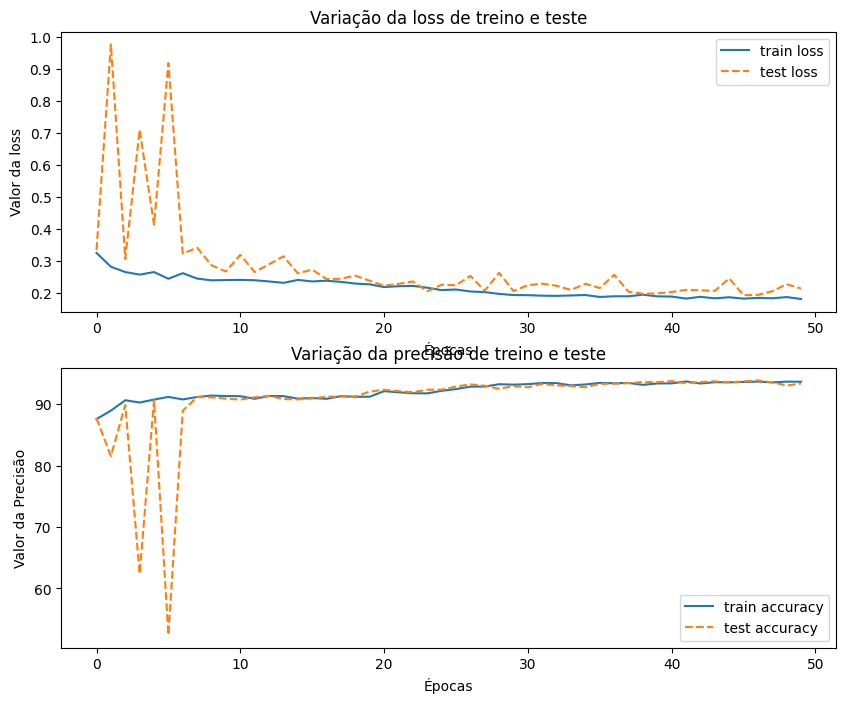

Loss: 1.00702 | Test Loss: 0.21276, Test Acc: 93.36%


In [ ]:
new_model = train_model(
    eff_b0_imgnet,
    dataloader_train,
    dataloader_validation,
    loss_fn,
    optimizer,
    'cuda',
    50,
    scheduler
)

In [ ]:
torch.save(new_model.state_dict(), f'{FOLDER_PATH}/new_model')

### Validando novo modelo

num_matrices: 2577
97.05083430345363


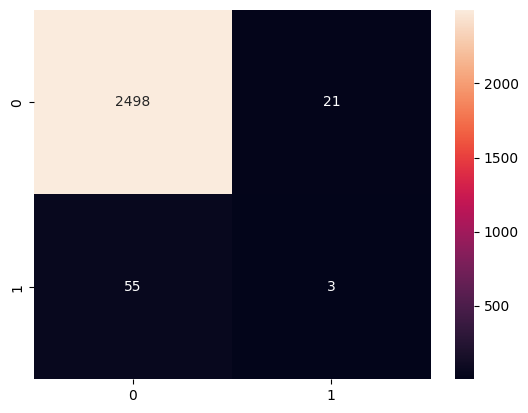

In [ ]:
fuzz_dataset, fuzz_labels = create_matrices_and_labels2(fuzz_df)
fuzz_dataset = CustomDataset(fuzz_dataset, fuzz_labels)

# Criar o DataLoader
fuzz_dataloader = DataLoader(fuzz_dataset, batch_size=1, shuffle=True)
print(get_model_accuracy(new_model, fuzz_dataloader))
print_confussion_matrix(new_model, fuzz_dataloader)

num_matrices: 3019
87.31368002649884


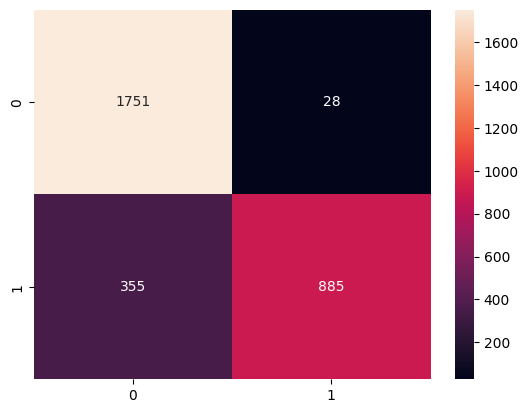

In [ ]:
dos_dataset, dos_labels = create_matrices_and_labels2(dos_df)
dos_dataset = CustomDataset(dos_dataset, dos_labels)

# Criar o DataLoader
dos_dataloader = DataLoader(dos_dataset, batch_size=1, shuffle=True)
print(get_model_accuracy(new_model, dos_dataloader))
print_confussion_matrix(new_model, dos_dataloader)

num_matrices: 2789
85.048404446038


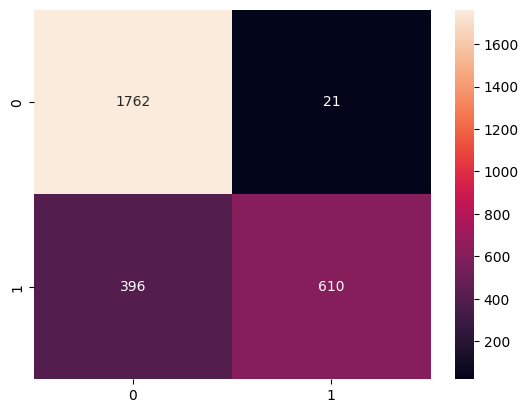

In [ ]:
false_dataset, false_labels = create_matrices_and_labels2(false_df)
false_dataset = CustomDataset(false_dataset, false_labels)

# Criar o DataLoader
false_dataloader = DataLoader(false_dataset, batch_size=1, shuffle=True)
print(get_model_accuracy(new_model, false_dataloader))
print_confussion_matrix(new_model, false_dataloader)

num_matrices: 2611
68.74760628111835


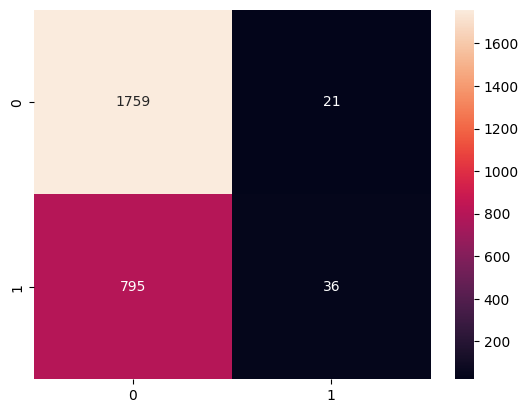

In [ ]:
impersonation_dataset, impersonation_labels = create_matrices_and_labels2(impersonation_df)
impersonation_dataset = CustomDataset(impersonation_dataset, impersonation_labels)

# Criar o DataLoader
impersonation_dataloader = DataLoader(impersonation_dataset, batch_size=1, shuffle=True)
print(get_model_accuracy(new_model, impersonation_dataloader))
print_confussion_matrix(new_model, impersonation_dataloader)